In [1]:
import random
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from math import log2
from collections import Counter
import copy
import matplotlib.pylab as plt
%config InlineBackend.figure_format = "svg"

## 画图

In [12]:
#用来正常显示中文
plt.rcParams['font.sans-serif']=['SimHei']
#用来正常显示负号
plt.rcParams['axes.unicode_minus']=False

def getNumLeafs(myTree):
    #初始化树的叶子节点的个数
    numLeafs = 0
    #myTree.keys()获取树的非叶子节点’no surfacing'和‘flippers’
    #list(mytree.keys()[0]获取第一个键名‘no surfacing’
    firstStr = list(myTree.keys())[0]
    #通过键名获取与之对应的值，即{0:'no',1:{'flippers':{0:'no,1:'yes'}}}
    secondDict = myTree[firstStr]
    #遍历树，secondDict.keys()获取所有的键
    for key in secondDict.keys():
        #判断键是否为字典，键名1和其值就组成了一个字典，如果是字典则通过递归继续遍历，寻找叶子节点
        if type(secondDict[key]).__name__=='dict':
            numLeafs += getNumLeafs(secondDict[key])
        #如果不是字典，则叶子节点的数目就加1
        else:
            numLeafs += 1
        #返回叶子节点的数目
    return numLeafs

def getTreeDepth(mytree):
    #初始化树的深度
    maxDepth = 0
    #获取树的第一个键名
    firstStr = list(mytree.keys())[0]
    #获取键名所对应的值
    secondDict = mytree[firstStr]
    #遍历树
    for key in secondDict.keys():
        #如果获取的键是字典，树的深度加一
        if type(secondDict[key]).__name__=='dict':
            thisDepth = 1+ getTreeDepth(secondDict[key])
        else:
            thisDepth = 1
        #去深度最大值
        if thisDepth > maxDepth : maxDepth = thisDepth
    #返回树的深度
    return maxDepth

#设置画节点用的盒子的样式
decisionNode = dict(boxstyle = 'sawtooth', fc='0.8')
leafNode = dict(boxstyle = 'round4', fc = '0.8')

#设置画箭头的样式
arrow_args = dict(arrowstyle="<-")
#绘图相关参数的设置
def plotNode(nodeTxt, centerPt, parentPt, nodeType):
    #annotate函数是为绘制图上指定的数据点xy添加一个nodeTxt注释
    #nodeTxt是给数据点xy添加一个注释，xy为数据点的开始绘制的坐标,位于节点的中间位置
    #xycoords设置指定点xy的坐标类型，xytext为注释的中间点坐标，textcoords设置注释点坐标样式
    #bbox设置装注释盒子的样式,arrowprops设置箭头的样式
    '''
        figure points:表示坐标原点在图的左下角的数据点
        figure pixels:表示坐标原点在图的左下角的像素点
        figure fraction：此时取值是小数，范围是([0,1],[0,1]),在图的左下角时xy是（0,0），最右上角是(1,1)
        其他位置是按相对图的宽高的比例取最小值
        axes points : 表示坐标原点在图中坐标的左下角的数据点
        axes pixels : 表示坐标原点在图中坐标的左下角的像素点
        axes fraction : 与figure fraction类似，只不过相对于图的位置改成是相对于坐标轴的位置
    '''
    createPlot.ax1.annotate(nodeTxt, xy=parentPt,
                            xycoords='axes fraction', xytext=centerPt, textcoords='axes fraction',
                            va='center', ha='center', bbox=nodeType, arrowprops=arrow_args)

#绘制线中间的文字（0和1）的绘制
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0] - cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1] - cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

#绘制树
def plotTree(myTree, parentPt, nodeTxt):
    #获取树的叶子节点
    numLeafs = getNumLeafs(myTree)
    #获取树的深度
    depth = getTreeDepth(myTree)
    #firstStr = mytree.keys()[0]
    #获取第一个键名
    firstStr = list(myTree.keys())[0]
    # 计算子节点的坐标
    cntrPt = (plotTree.xoff + (1.0 + float(numLeafs)) / 2.0 / plotTree.totalW, plotTree.yoff)
    # 绘制线上的文字
    plotMidText(cntrPt, parentPt, nodeTxt)
    # 绘制节点
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    # 获取第一个键值
    secondDict = myTree[firstStr]
    # 计算节点y方向上的偏移量，根据树的深度
    plotTree.yoff = plotTree.yoff - 1.0 / plotTree.totalD
    for key in secondDict.keys():
        if type(secondDict[key]).__name__ == 'dict':
            # 递归绘制树
            plotTree(secondDict[key], cntrPt, str(key))
        else:
            # 更新x的偏移量,每个叶子结点x轴方向上的距离为 1/plotTree.totalW
            plotTree.xoff = plotTree.xoff + 1.0 / plotTree.totalW
            # 绘制非叶子节点
            plotNode(secondDict[key], (plotTree.xoff, plotTree.yoff), cntrPt, leafNode)
            # 绘制箭头上的标志
            plotMidText((plotTree.xoff, plotTree.yoff), cntrPt, str(key))
    plotTree.yoff = plotTree.yoff + 1.0 / plotTree.totalD

#绘制决策树，inTree的格式为{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}}
def createPlot(inTree):
    #新建一个figure设置背景颜色为白色
    fig = plt.figure(1,facecolor='white')
    #清除figure
    fig.clf()
    axprops = dict(xticks=[],yticks=[])
    #创建一个1行1列1个figure，并把网格里面的第一个figure的Axes实例返回给ax1作为函数createPlot()
    #的属性，这个属性ax1相当于一个全局变量，可以给plotNode函数使用
    createPlot.ax1 = plt.subplot(111,frameon=False,**axprops)
    #获取树的叶子节点
    plotTree.totalW = float(getNumLeafs(inTree))
    #获取树的深度
    plotTree.totalD = float(getTreeDepth(inTree))
    #节点的x轴的偏移量为-1/plotTree.totlaW/2,1为x轴的长度，除以2保证每一个节点的x轴之间的距离为1/plotTree.totlaW*2
    plotTree.xoff = -0.5/plotTree.totalW
    plotTree.yoff = 1.0
    plotTree(inTree,(0.5,1.0),'')
    plt.show()

# C4.5

In [2]:
#计算熵值
import math
def calcEnt(dataSet):
    labels = set([dataVec[-1] for dataVec in dataSet])
    labelSet = {}
    for label in labels:
        labelSet[label] = 0
    #样本总个数
    totalNum = len(dataSet)
    #类别集合
    #计算每个类别的样本个数
    for dataVec in dataSet:
        label = dataVec[-1]
        if label not in labelSet.keys():
            labelSet[label] = 0
        labelSet[label] += 1
    Ent = 0
    #计算熵值
    for key in labelSet:
        pi = float(labelSet[key])/totalNum
        Ent -= pi*math.log(pi,2)
    #print labelSet
    return Ent

In [373]:
#按给定特征划分数据集:返回第featNum个特征其值为value的样本集合，且返回的样本数据中已经去除该特征
def splitDataSet(dataSet, featNum, featvalue):
    retDataSet = []
    for dataVec in dataSet:
        if dataVec[featNum] == featvalue:
            splitData = dataVec[:featNum]
            splitData = np.append(splitData,dataVec[featNum+1:])
            retDataSet.append(splitData)
    return np.array(retDataSet)

In [179]:
#选择最好的特征划分数据集
def chooseBestFeatToSplit(dataSet, labelSet):
    featNum = len(dataSet[0]) - 1
    maxInfoGain = 0
    bestFeat = -1
    #计算样本熵值
    baseEnt = calcEnt(dataSet)
    #以每一个特征进行分类，找出使信息增益最大的特征
    for i in range(featNum):
        featList = [dataVec[i] for dataVec in dataSet]
        featList = set(featList)
        newEnt = 0
        #计算以第i个特征进行分类后的熵值，对应公式中：H(X|Y)
        for featValue in featList:
            subDataSet = splitDataSet(dataSet, i, featValue)
            prob = len(subDataSet)/float(len(dataSet))
            newEnt += prob*calcEnt(subDataSet)
        #C4.5算法：计算信息增益比
        selfClass = np.array([dataVec[i] for dataVec in dataSet]).reshape(-1,1)
        infoGain = (baseEnt - newEnt)/(calcEnt(selfClass)+1e-9)
        #找出最大的熵值以及其对应的特征
        if infoGain > maxInfoGain:
            maxInfoGain = infoGain
            bestFeat = i
    print(maxInfoGain)
    return bestFeat

In [235]:
#选择最好的特征划分数据集
def chooseBestFeatToSplit2(dataSet, labelSet, esp):
    featNum = len(dataSet[0]) - 1
    maxInfoGain = -1
    bestFeat = -1
    #计算样本熵值
    baseEnt = calcEnt(dataSet)
    #以每一个特征进行分类，找出使信息增益最大的特征
    for i in range(featNum):
        featList = [dataVec[i] for dataVec in dataSet]
        featList = set(featList)
        newEnt = 0
        #计算以第i个特征进行分类后的熵值，对应公式中：H(X|Y)
        for featValue in featList:
            subDataSet = splitDataSet(dataSet, i, featValue)
            prob = len(subDataSet)/float(len(dataSet))
            newEnt += prob*calcEnt(subDataSet)
        #C4.5算法：计算信息增益比
        selfClass = np.array([dataVec[i] for dataVec in dataSet]).reshape(-1,1)
        infoGain = (baseEnt - newEnt)/(calcEnt(selfClass)+1e-9)
        #找出最大的熵值以及其对应的特征
        if infoGain > maxInfoGain:
            maxInfoGain = infoGain
            bestFeat = i
    if maxInfoGain < esp:
        return -1
    else: 
        return bestFeat

In [5]:
#如果决策树递归生成完毕，且叶子节点中样本不是属于同一类，则以少数服从多数原则确定该叶子节点类别
def majorityCnt(labelList):
    labels = set(labelList)
    labelSet = {}
    for label in labels:
        labelSet[label] = 0
    #统计每个类别的样本个数
    for label in labelList:
        if label not in labelSet.keys():
            labelSet[label] = 0
        labelSet[label] += 1
    #iteritems：返回列表迭代器
    #operator.itemgeter(1):获取对象第一个域的值
    #True：降序
    sortedLabelSet = sorted(labelSet.items(), key=operator.itemgetter(1), reverse=True)
    return sortedLabelSet[0][0]

In [142]:
import operator

#创建决策树
def createDecideTree(dataSet, featName):
    #数据集的分类类别
    classList = [dataVec[-1] for dataVec in dataSet]
    #所有样本属于同一类时，停止划分，返回该类别
    if len(classList) == classList.count(classList[0]):
        return classList[0]
    #所有特征已经遍历完，停止划分，返回样本数最多的类别
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    #选择最好的特征进行划分
    bestFeat = chooseBestFeatToSplit(dataSet, featName)
    bestFeatName = featName[bestFeat]
    #print "当前最佳属性是", bestFeatName
    del featName[bestFeat]
    #以字典形式表示树
    DTree = {bestFeatName:{}}
    #根据选择的特征，遍历该特征的所有属性值，在每个划分子集上递归调用createDecideTree
    featValue = [dataVec[bestFeat] for dataVec in dataSet]
    featValue = set(featValue)
    #print "剩余候选属性是", featName
    for value in featValue:
        subFeatName = featName[:]
        DTree[bestFeatName][value] = createDecideTree(splitDataSet(dataSet,bestFeat,value), subFeatName)
    return DTree

In [320]:
import operator

#创建决策树
def createDecideTree2(dataSet, featName, stopCount, eps):
    #数据集的分类类别
    classList = [dataVec[-1] for dataVec in dataSet]
    #所有样本属于同一类时，停止划分，返回该类别
#     if len(classList) == classList.count(classList[0]):
#         return classList[0]
    if len(set(classList)) == 1:
        return classList[0]
    #所有特征已经遍历完，停止划分，返回样本数最多的类别
    if len(dataSet[0]) == 1:
        return majorityCnt(classList)
    if len(dataSet) <= stopCount:
        return majorityCnt(classList)
    #选择最好的特征进行划分
    bestFeat = chooseBestFeatToSplit2(dataSet, featName,eps)
    if bestFeat == -1:
        return majorityCnt(classList)
    bestFeatName = featName[bestFeat]
    del featName[bestFeat]
    #以字典形式表示树
    DTree = {bestFeatName:{}}
    #根据选择的特征，遍历该特征的所有属性值，在每个划分子集上递归调用createDecideTree
    featValue = [dataVec[bestFeat] for dataVec in dataSet]
    featValue = set(featValue)
    for value in featValue:
        subFeatName = featName[:]
        DTree[bestFeatName][value] = createDecideTree2(splitDataSet(dataSet,bestFeat,value),\
                                                       subFeatName,\
                                                       stopCount,\
                                                       eps)
    return DTree

In [11]:
#C4.5剪枝
import copy

def isTree(obj):#判断当前节点是否是叶节点
    return (type(obj).__name__ == 'dict')

def prune(tree, testData, featList):
    newTree = copy.deepcopy(tree)
    firstFeat = list(tree.keys())[0]
    secondDict = tree[firstFeat]
    #print firstFeat
    for key in secondDict.keys():
        #print key
        if isTree(secondDict[key]):
            featNum = featList.index(firstFeat)
            subSample = splitDataSet(testData, featNum, key)
            subclassList = [dataVec[-1] for dataVec in subSample]
            if len(subclassList)!=0:
                if len(subclassList) == subclassList.count(subclassList[0]):
                    tree[firstFeat][key] = majorityCnt(subclassList)
                else:
                    newTree[firstFeat][key] = majorityCnt(subclassList)
                    precison_old = precisionCal(tree, featList, testData)
                    precision_new = precisionCal(newTree, featList, testData)
                    if precision_new > precison_old:
                        tree[firstFeat][key] = majorityCnt(subclassList)
                    else:
                        newfeatList = featList[:featNum] + featList[featNum + 1:]
                        tree[firstFeat][key] = prune(secondDict[key], subSample, newfeatList)
            else:
                continue
    return tree  

In [202]:
def load_data_and_split(data_path='./nursery.data', val_rate=0.2):
    """
    加载数据集并划分训练集和验证集
    :param data_path: 数据集路径
    :param val_rate: 验证集比例
    :return: 训练集列表，验证集列表
    """
    with open('./nursery.data','r') as openfile:
        data_lines = openfile.read().splitlines()  # 读取文件的所有行，忽略换行符
    val_lines = random.sample(data_lines,k=int(len(data_lines)*val_rate))
    train_data = np.array([])
    val_data = np.array([])
    cnt = []
    for data_line in data_lines:
        if data_line in val_lines:
            data_line = np.array(data_line.split(","))
            if len(data_line) == 9:
                val_data = np.append(val_data,data_line)
        else:
            data_line = np.array(data_line.split(","))
            if len(data_line) == 9:
                train_data = np.append(train_data,data_line)
    return train_data.reshape(-1,9),val_data.reshape(-1,9)

In [367]:
def classify(inputTree, featLabels, testVec):
    firstStr = list(inputTree.keys())[0]
    # 获取根结点对应的子节点
    secondDict = inputTree[firstStr]
    # 获取根结点名称在标签列表中对应的索引
    featIndex = featLabels.index(firstStr)
    # 由索引获取向量表中的对应值
    key = testVec[featIndex]
    # 获取树干向量后的对象
    if key not in list(secondDict.keys()):
        return "wrong"
    valueOfFeat = secondDict[key]
    # 判断是子结点还是叶子节点：子结点就回调分类函数，叶子结点就是分类结果
    if isinstance(valueOfFeat, dict):
        classLabel = classify(valueOfFeat, featLabels, testVec)
    else:
        classLabel = valueOfFeat
    return classLabel

In [369]:
def getCurracy(inputTree,featLabels,dataSet):
    curr = 0
    for data in dataSet:
        if classify(inputTree,featLabels,data) == data[-1]:
            curr += 1
    return curr/(len(dataSet)+1e-9)

In [356]:
train_data, val_data = load_data_and_split()

In [371]:
# 0.12 200
labels = ['parents','has_nurs','form','children','housing','finance','social','health','recommend']
DT = createDecideTree2(train_data,labels[:],eps=0.12, stopCount = 500)
# tree = copy.deepcopy(DT)
# newDT = prune(tree, val_data, labels[:])
createPlot(DT)
# createPlot(newDT)

print(getCurracy(DT,labels,train_data))
print(getCurracy(DT,labels,val_data))
# print(precisionCal(newDT,labels,train_data))
# print(precisionCal(newDT,labels,val_data))

0.8930362654320126
0.8885030864194103


In [237]:
# fr = open('lenses.txt')
# lenses = [inst.strip().split('\t') for inst in fr.readlines()]
# val_data = random.sample(lenses, k=(int)(len(lenses)*0.3))
# train_data = []
# for lense in lenses:
#     if lense not in val_data:
#         train_data.append(lense)

# lenses_labels = ['age', 'prescript','astigmatic','tear_rate']
# train_data,val_data = np.array(train_data), np.array(val_data)
# DT = createDecideTree(train_data,lenses_labels[:])
# tree = copy.deepcopy(DT)
# newDT = prune(tree, val_data, lenses_labels[:])
# createPlot(DT)
# createPlot(newDT)

In [31]:
def E(a,b):
    return a*log2(a) + b*log2(b)

0.4*E(3/4,1/4)+0.6*E(1/6,5/6)

-0.7145247027726656

In [28]:
def G(a,b):
    return 1-a**2-b**2
0.48-0.4*G(3/4,1/4)-0.6*G(1/6,5/6)

0.16333333333333336

['性别', '学生干部', '综合成绩', '毕业论文', '就业情况']


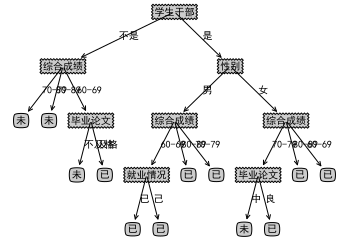

In [146]:
with open('a.txt',encoding='utf-8') as f:
    fr = f.readlines()
tempDataSet = [line.strip('\n') for line in fr]
tempDataSet = np.array(tempDataSet).reshape(-1,6)
labels = list(tempDataSet[0][1 :])
print(labels)
dataSet = tempDataSet[1 :][:,1 :]
# print(dataSet)
tree = createDecideTree(dataSet,labels[:])
createPlot(tree)

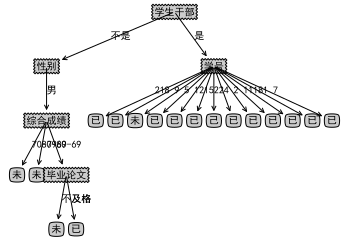

In [73]:
labels = list(tempDataSet[0])
dataSet2 = tempDataSet[1 :]
DT = createDecideTree(dataSet2,labels[:])
createPlot(DT)
# createPlot(newDT)